## Задание
* Проанализировать ранее загруженный DataFrame.
* Построить графики используя matplotlib, seaborn.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# считываем данные из файла
data = pd.read_pickle('output.pkl')

In [ ]:
# отбираем столбцы для задания
pd.options.display.max_rows = 108
data.iloc[4]

id                                                                                       13399
pdId                                                                                     28141
region                                                                                      72
address                                                        г Тюмень, ул Профсоюзная, д. 56
objElemLivingCnt                                                                             0
objReady100PercDt                                                                   2024-12-31
wallMaterialShortDesc                                                                   Другое
objLkFinishTypeDesc                                                                Без отделки
objLkFreePlanDesc                                                                          Нет
objElemParkingCnt                                                                          125
objSquareLiving                                   

In [ ]:
# создаем рабочий дата фрейм
columns = ['id', 'region', 'objReady100PercDt', 'objFloorCnt', 'objElemLivingCnt',
 'objFlatSq', 'objElemParkingCnt', 'objPriceAvg']

new_name_columns = ['id', 'region', 'commissioning_date', 'floor_count', 'flat_count',
                   'flat_square', 'parking_count', 'one_meter_price']

work_df = data[columns].rename(columns=dict(zip(columns, new_name_columns)))
work_df.head(2)

,id,region,commissioning_date,floor_count,flat_count,flat_square,parking_count,one_meter_price
0,29679,61,2020-03-31,NaN,18,1519.0,0,NaN
1,29678,61,2020-03-31,NaN,27,1519.0,0,NaN


In [ ]:
# тип столбцов и количество пропущенных значений
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10528 entries, 0 to 10527
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10528 non-null  int64  
 1   region              10528 non-null  int64  
 2   commissioning_date  10528 non-null  object 
 3   floor_count         10526 non-null  float64
 4   flat_count          10528 non-null  int64  
 5   flat_square         10528 non-null  object 
 6   parking_count       10528 non-null  int64  
 7   one_meter_price     7634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 658.1+ KB


In [ ]:
# корректровка типа столбцов
work_df.commissioning_date = pd.to_datetime(work_df.commissioning_date)
work_df = work_df.astype({'flat_square': float})

In [ ]:
work_df.dtypes

id                             int64
region                         int64
commissioning_date    datetime64[ns]
floor_count                  float64
flat_count                     int64
flat_square                  float64
parking_count                  int64
one_meter_price              float64
dtype: object

In [ ]:
# выделяем год ввода в эксплуатацию
work_df['com_year'] = work_df['commissioning_date'].dt.year

In [ ]:
work_df.isnull().sum(axis = 0)

id                       0
region                   0
commissioning_date       0
floor_count              2
flat_count               0
flat_square              0
parking_count            0
one_meter_price       2894
com_year                 0
dtype: int64

In [ ]:
# группируем по регионам и находим среднюю цену 
gr_reg_df = work_df.groupby(by='region', as_index=False).one_meter_price.mean().round()

In [ ]:
# расчитываем медианную цену
gr_reg_df['median'] = gr_reg_df.one_meter_price.median()
gr_reg_df.set_index('region').head(2)

,one_meter_price,median
region,,
1,62361.0,70175.0
2,75723.0,70175.0


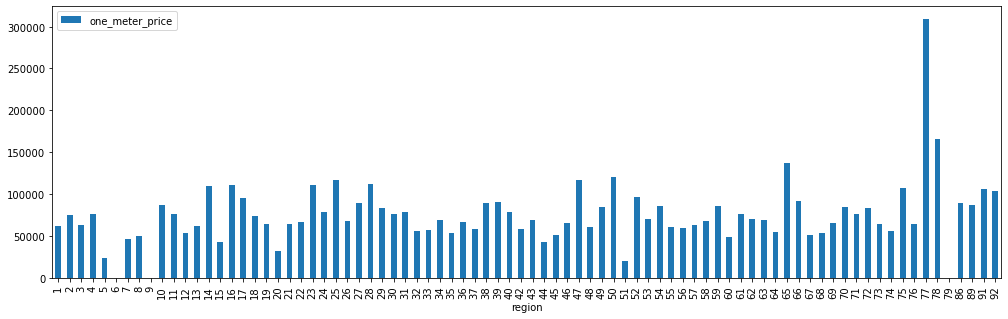

In [ ]:
# диаграмма в pandas
gr_reg_df.plot(x='region', y=['one_meter_price'], kind='bar', figsize=(17,5))
plt.show()

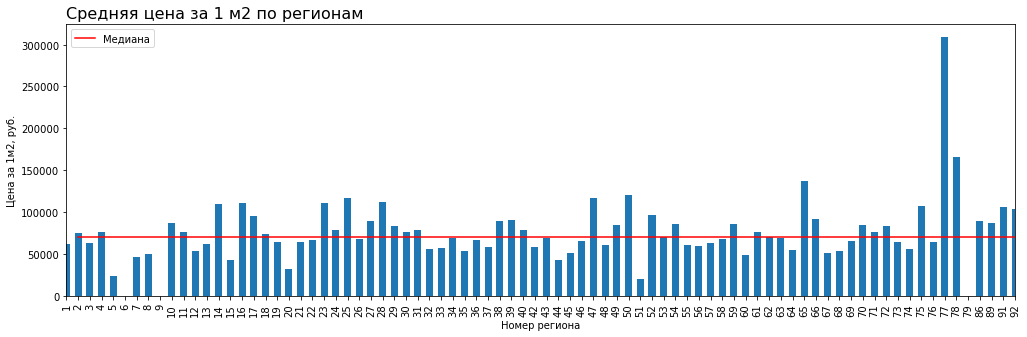

In [ ]:
# диаграмма в matplotlib
plt.figure(figsize=(17,5))
plt.bar(gr_reg_df.region.astype('str'), gr_reg_df.one_meter_price, width=0.6)
plt.plot(gr_reg_df['region'], gr_reg_df['median'], color='red', label='Медиана')
plt.xticks(rotation=90)
plt.xlim(['1', "92"])
plt.title('Средняя цена за 1 м2 по регионам', fontsize=16, loc='left')
plt.xlabel('Номер региона')
plt.ylabel('Цена за 1м2, руб.')
plt.legend(loc='upper left')
plt.show()

Вывод: 
-  самое дорогое жилье в Москве - 309 тыс.руб за 1м2
-  жилье в Санкт-Петербурге почти в 2 раза дешевле - 166 тыс.руб за 1м2
-  самое дешовое жилье в Мурманской области - 20 тыс.руб за 1м2
-  медианная цена жилья по России - 70 тыс.руб за 1м2

In [ ]:
# заполняем пустые значения цены средними значениями по регионам
mean_prices = dict(zip(gr_reg_df['region'], gr_reg_df['one_meter_price']))

mask = work_df['one_meter_price'].astype('str').isin(['NaN','nan'])
work_df.loc[mask, 'one_meter_price'] = work_df.loc[mask, 'region'].map(mean_prices)

In [ ]:
work_df.isnull().sum(axis=0)

id                    0
region                0
commissioning_date    0
floor_count           2
flat_count            0
flat_square           0
parking_count         0
one_meter_price       5
com_year              0
dtype: int64

In [ ]:
# группируем по регионам и годам объемы строительтсва жилья
group_region = work_df.groupby(['region'], as_index=False) \
    .aggregate({'id': 'count', 'flat_square': 'sum'}) \
    .rename(columns={'id': 'flat_count', 'flat_square': 'sum_flat_square'})

group_year = work_df.groupby(['com_year'], as_index=False) \
    .aggregate({'id': 'count', 'flat_square': 'sum'}) \
    .rename(columns={'id': 'flat_count', 'flat_square': 'sum_flat_square'})

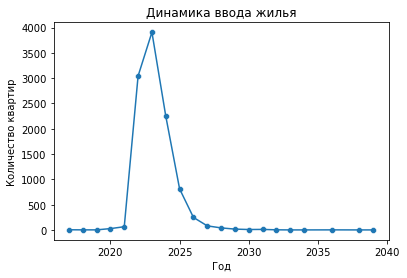

In [ ]:
# линейный график в seabon
sns.lineplot(data=group_year, x='com_year', y='flat_count')
sns. (data=group_year, x='com_year', y='flat_count')
plt.title('Динамика ввода жилья')
plt.xlabel('Год')
plt.ylabel('Количество квартир')
plt.show()

Вывод: максимальное количество квартир будет сдано в 2023 году

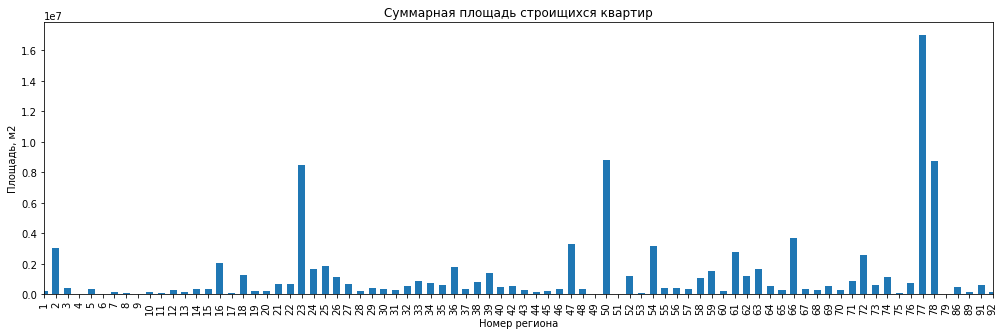

In [ ]:
# диаграмма в matplotlib
plt.figure(figsize=(17,5))
plt.bar(group_region.region.astype('str'), group_region.sum_flat_square, width=0.6)
plt.xticks(rotation=90)
plt.xlim(['1', "92"])
plt.title('Суммарная площадь строищихся квартир')
plt.xlabel('Номер региона')
plt.ylabel('Площадь, м2')
plt.show()

Вывод: лидерами по строительству жилья являются: Москва, Санкт_Петербург, Московская область, Краснодарский край

In [ ]:
# отбираем данные по москве и краснодарскому краю

Mosсow = work_df[work_df.region == 77]
Krasnodar_region = work_df[work_df.region == 23]
Mosсow.head(2)

,id,region,commissioning_date,floor_count,flat_count,flat_square,parking_count,one_meter_price,com_year
10,27476,77,2022-09-30,15.0,99,5589.5,0,203870.0,2022
30,20524,77,2023-06-30,34.0,396,20225.0,0,207678.0,2023


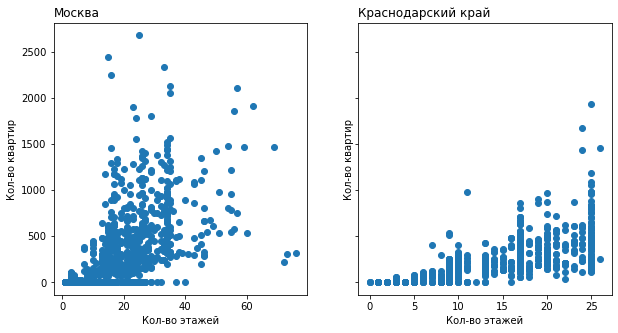

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1, ax2 = ax
ax1.scatter(x=Mosсow.floor_count, y=Mosсow.flat_count)
ax1.set_title('Москва', loc='left')
ax1.set_xlabel('Кол-во этажей')
ax1.set_ylabel('Кол-во квартир')
ax2.scatter(x=Krasnodar_region.floor_count, y=Krasnodar_region.flat_count)
ax2.set_title('Краснодарский край', loc='left')
ax2.set_xlabel('Кол-во этажей')
ax2.set_ylabel('Кол-во квартир')
fig.set_size_inches(10,5)
plt.subplots_adjust(wspace=0.2)
plt.show()

Вывод: линейной зависимости количества квартир от количества этажей не наблюдается

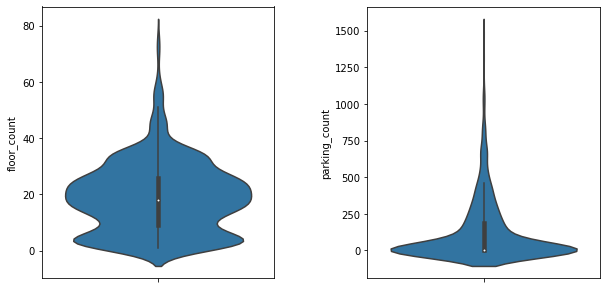

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax
sns.violinplot(data=Mosсow, y='floor_count', ax=ax1)
sns.violinplot(data=Mosсow, y='parking_count', ax=ax2)
fig.set_size_inches(10,5)
plt.subplots_adjust(wspace=0.4)
plt.show()

Вывод:
-  в Москве наибольшее кол-во строяшихся зданий 20 этажные
-  как правило, в Москве строящиеся дома не содержат парковочных мест